In [1]:
import os
import pandas as pd
import matplotlib.pylab as plt

In [2]:
train = pd.read_csv('/Users/guoli/Desktop/kaggle/Porto/train.csv',usecols=['target'],nrows=10000)
test = pd.DataFrame()

In [3]:
foldernames = os.popen('ls data').readlines()

In [4]:
for foldername in foldernames:
    foldername = foldername[:-1]
    train[foldername] = pd.read_csv('data/{0}/train4stack.csv'.format(foldername),nrows=10000)
    #test[foldername] = pd.read_csv('data/{0}/test4stack.csv'.format(foldername))

In [5]:
train.head()

,target,changlin_20171108_1,changlin_20171108_2,guoli_20171108,guoli_20171109,mubi_20171109,tian_20171109
0,0,0.044521,0.046646,0.994861,0.883679,0.047776,0.265382
1,0,0.035425,0.033705,1.047057,0.618817,0.035362,0.256079
2,0,0.017495,0.021387,1.272133,0.641586,0.026082,0.252894
3,0,0.033988,0.014646,0.477906,0.542949,0.023179,0.251246
4,0,0.031818,0.031650,0.769130,0.565832,0.031547,0.248128


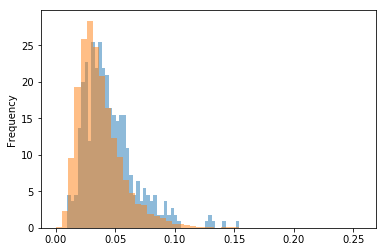

In [6]:
train[train.target==1]['changlin_20171108_1'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
train[train.target==0]['changlin_20171108_1'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
plt.show()

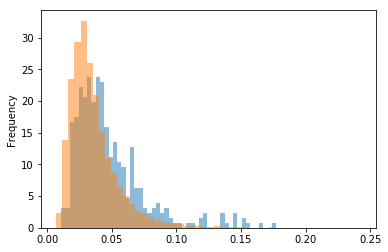

In [7]:
train[train.target==1]['changlin_20171108_2'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
train[train.target==0]['changlin_20171108_2'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
plt.show()

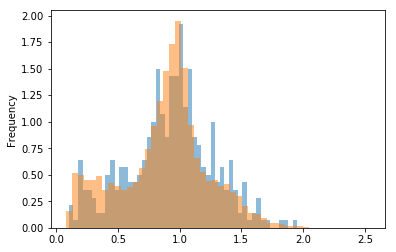

In [8]:
train[train.target==1]['guoli_20171108'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
train[train.target==0]['guoli_20171108'].plot(kind='hist',bins=50,alpha=0.5,normed=True)
plt.show()

In [9]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_coefficient(preds,dtrain):
    y = dtrain.get_label()
    return 'gini', -gini_normalized(y,preds)

In [10]:
from sklearn.model_selection import KFold

class CustomGridCV(object):
    def __init__(self, X, y, model, metric, griddata, cv=5):
        self.X = X
        self.y = y
        self.model = model
        self.metric = metric
        self.params = self.gridpoints(griddata)
        self.cv = cv
        self.bestScore = None
        self.bestParams = None
        
    def gridpoints(self, data):
        newparams = [{}]
        for k in data.keys():
            params = newparams
            newparams = []
            for v in data[k]:
                for param in params:
                    item = param.copy()
                    item[k]=v
                    newparams.append(item)           
        return newparams
    
    def GridSearch(self):
        for param in self.params:
            self.model.set_params(**param)
            score = self.KFoldScore()
            if self.bestScore==None or self.bestScore<score:
                self.bestScore = score
                self.bestParams = param
            print("Score: {0:.5f}, Params: {1}".format(score,param))
    
    def KFoldScore(self):
        kf = KFold(n_splits=5, shuffle=True, random_state=2)
        y_pred = np.zeros(len(self.y))

        for train_index, test_index in kf.split(self.X):
            train_X, test_X = self.X[train_index], self.X[test_index]
            train_y, test_y = self.y[train_index], self.y[test_index]
            self.model.fit(train_X,train_y)
            y_pred[test_index] = self.model.predict(test_X)

        return self.metric(self.y,y_pred)
    
    def Best(self):
        return self.bestScore, self.bestParams

In [11]:
import pandas as pd
import numpy as np

def PrepareData(df):
    #df = pd.read_csv(trainpath,nrows=nrows)

    features = list(df.columns)
    target = 'target'
    features.remove(target)

    X = np.array(df[features])
    y = np.array(df[target])
    return X, y

In [12]:
X, y = PrepareData(train)

In [16]:
from sklearn.ensemble import RandomForestRegressor
#X, y = PrepareData(train)
model = RandomForestRegressor(n_jobs=-1,max_depth=2)
griddata = {'n_estimators':[20,50,100,200,300]}
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)
GCV.GridSearch()

Score: 0.28724, Params: {'n_estimators': 20}
Score: 0.26672, Params: {'n_estimators': 50}
Score: 0.26606, Params: {'n_estimators': 100}
Score: 0.27103, Params: {'n_estimators': 200}
Score: 0.27106, Params: {'n_estimators': 300}


In [14]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(50,n_jobs=-1,max_depth=3)

model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [15]:
print model.feature_importances_

[ 0.06843079  0.5291048   0.04084651  0.09377237  0.16169958  0.10614596]


In [75]:
print gini_normalized(y,model.predict(X))

0.434046400807


In [68]:
#model.predict_proba(np.array(test))[:,1]

In [144]:
result = pd.read_csv('/Users/guoli/Desktop/kaggle/Porto/test.csv',usecols=['id'])
result['target'] = model.predict_proba(np.array(test))[:,1]

In [146]:
result.head()

,id,target
0,0,0.026132
1,1,0.025951
2,2,0.025694
3,3,0.021864
4,4,0.029668


In [147]:
result.to_csv('xgb_nn_encoder.csv',index=False)

In [148]:
! head xgb_nn_encoder.csv

id,target
0,0.0261317432156
1,0.0259512759203
2,0.0256943898781
3,0.021864325779
4,0.0296683108862
5,0.0333643762681
6,0.0218926572291
8,0.0292410953604
10,0.0391363268473
